# Model training for NFL play prediction

---
 
In this notebook, we train multiple regression and ANN models to predict the yards gained per football play. As a basis we use the preselected data created by the `preprocessing.py``.

### Inline preprocessing steps:

---

As we use 5-fold cross-validation to protect the model against overfitting, we need a dynamic preprocessing appraoch. Therefore a pipeline provided by the `preprocessing.py`` will be used to process the training data of each fold. Further we use a nested cross validation to ensure the quality of our model using selected hyperparameters.


### Contributors

All contributors are only assigned to their primary task, the teams still interchanged know-how and worked on one anothers approaches.

---

##### Preprocessing Team

- Tim Oliver Krause (1689074)
- Jan Thilo Viktorin (1684159)
- Joël Pflomm (1634591)

##### Model Team

- Franziska Köllschen (1981780)
- Steffen Hüls (1979863)
- Matthias Biermanns (1980701)

## Coding

### Coding Foundations

In [13]:
# basic imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.base import TransformerMixin, BaseEstimator
import preprocessing

# import for data visualization
import matplotlib.pyplot as plt

# imports for regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

import xgboost as xgb

In [14]:
# static variables
FILE_LIST = [f'./Data/play_by_play_{year}.csv' for year in range(1999, 2001)]
PREPROCESSOR = preprocessing.NFLPreprocessing(FILE_LIST)
TARGET_NAME = 'yards_gained'
RANDOM_STATE = 42
LABEL_PASS = 'Pass'
LABEL_RUN = 'Run'

2023-12-02 22:43:03.632 | INFO     | preprocessing:__init__:56 - --- Executing Preprocessing Steps ---
2023-12-02 22:43:03.633 | INFO     | preprocessing:make_combined_df:143 - Loading csv files
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:148: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
c:\Users\mbier\VSCodeProjects\NFL_play_prediction\preprocessing.py:148: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)
2023-12-02 22:43:05.395 | INFO     | preprocessing:make_combined_df:153 - Successfully loaded csv files
2023-12-02 22:43:05.426 | INFO     | preprocessing:drop

##### General functions

In [47]:
def get_sample(df, data_fraction):
    # set fraction between 0 and 1 (e.g. 0.05 -> 5% df)
    df_sampled = df.sample(frac=data_fraction, random_state=RANDOM_STATE)

    # Reset the index if needed
    df_sampled = df_sampled.reset_index(drop=True)

    return df_sampled

def split_feature_target(df):
    features = df.drop(TARGET_NAME, axis=1)
    target = df[TARGET_NAME]

    return features, target

def visualize_predicts(y_test, predictions, label):
    # Visualize predictions for passes
    plt.scatter(y_test, predictions)
    plt.title(label + ' Model: True vs Predicted Yards')
    plt.xlabel('True Yards')
    plt.ylabel('Predicted Yards')
    plt.show()

def plot_decision_tree(tree, label):
    # Plot the decision tree for runs
    plt.figure(figsize=(15, 10))
    plot_tree(tree, filled=True, feature_names=PREPROCESSOR.get_prepro_feature_names_from_pipeline())
    plt.title('Decision Tree for ' + label + ' Model')
    plt.show()

def visualize_train_val_loss(training_losses, validation_losses, label):
    # Plot the training and validation loss
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Neural Network Training and Validation Loss - ' + label)
    plt.legend()
    plt.show()

def plot_feature_importances(pipeline, label, show_top_n=10):
    # Get feature importances
    feature_importances = pipeline.named_steps['regressor'].feature_importances_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:show_top_n], feature_importance_df['Importance'][:show_top_n])
    plt.xlabel('Importance')
    plt.title(f'Top {show_top_n} Feature Importances - {label}')
    plt.show()

def plot_coef(pipeline):
    coefs = pipeline.named_steps['regressor'].coef_

    # Get the feature names after preprocessing
    columns = PREPROCESSOR.get_prepro_feature_names_from_pipeline()

    coef = pd.DataFrame(coefs, columns=["Coefficients"], index=columns)
    coef.plot(kind="barh", figsize=(9, 7))
    plt.figure(figsize=(10, 6))
    plt.title("Ridge model")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)

##### Functions for cross validation

In [72]:
def test_model(pipeline, df, data_fraction: float = None, label = None):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(data, data_fraction)
    
    features, target = split_feature_target(data)
    X_train, X_test, y_train, y_test = train_test_split(features, target)

    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = pipeline.predict(X_test)

    visualize_predicts(y_test, predictions, label if label else '')

    # Evaluate the models
    pass_mse = mean_squared_error(y_test, predictions)
    pass_rmse = mean_squared_error(y_test, predictions, squared = False)
    pass_msa = mean_absolute_error(y_test, predictions)

    print(f"Mean Squared Error: {pass_mse}")
    print(f"Mean Absolute Error: {pass_msa}")
    print(f"Root Mean Squared Error: {pass_rmse}")
    return y_test, predictions

def test_model_k_fold(df, pipeline, data_fraction: float = None, k_folds: int=5):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)
    
    features, target = split_feature_target(data)
    
    cv_results = cross_val_predict(pipeline, features, target, cv=k_folds)
    return cv_results

def estimate_hyperparams(df, pipeline, scoring, k_folds=3, parameters={}, data_fraction: float = 1.0):
    data = df.copy()
    if(data_fraction and data_fraction < 1.0):
        data = get_sample(df, data_fraction)

    features, target = split_feature_target(data)
    
    # create the grid search instance
    grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=scoring, cv=k_folds, return_train_score=False)

    # run the grid search
    grid_search_estimator.fit(features, target)
    
    display(grid_search_estimator.best_params_)
    display(pd.DataFrame(grid_search_estimator.cv_results_))

    return grid_search_estimator

def generate_param_combinations(parameters):
    '''list of list required for cross product of two lists'''
    return list(ParameterGrid(parameters))

##### MLP Regressor Class - with history

In [17]:
class MLPWithHistory(BaseEstimator, TransformerMixin):
    def __init__(self, mlp_params=None):
        self.mlp_params = mlp_params
        self.training_losses = []
        self.validation_losses = []
        self.mlp_regressor = MLPRegressor(**(self.mlp_params or {}))

    def fit(self, X, y):
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        for epoch in range(self.mlp_regressor.max_iter):
            self.mlp_regressor.partial_fit(X, y)

            # Calculate training loss
            y_train_pred = self.mlp_regressor.predict(X)
            training_loss = mean_squared_error(y, y_train_pred)
            self.training_losses.append(training_loss)

            # Calculate validation loss
            y_val_pred = self.mlp_regressor.predict(X_val)
            validation_loss = mean_squared_error(y_val, y_val_pred)
            self.validation_losses.append(validation_loss)

        return self

    def transform(self, X):
        return X

    def predict(self, X):
        return self.mlp_regressor.predict(X)

    def get_params(self, deep=True):
        return {"mlp_params": self.mlp_params}

    def set_params(self, **params):
        self.mlp_params = params["mlp_params"]
        self.mlp_regressor.set_params(**self.mlp_params)
        return self
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

##### Train and Test Data

In [18]:
run_df = PREPROCESSOR.run_df
pass_df = PREPROCESSOR.pass_df

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

run_X_train, run_X_test, run_y_train, run_y_test = train_test_split(run_features, run_target)
pass_X_train, pass_X_test, pass_y_train, pass_y_test = train_test_split(pass_features, pass_target)

print(run_features.shape)
print(pass_features.shape)

(27317, 24)
(32303, 24)


### Linear Regression

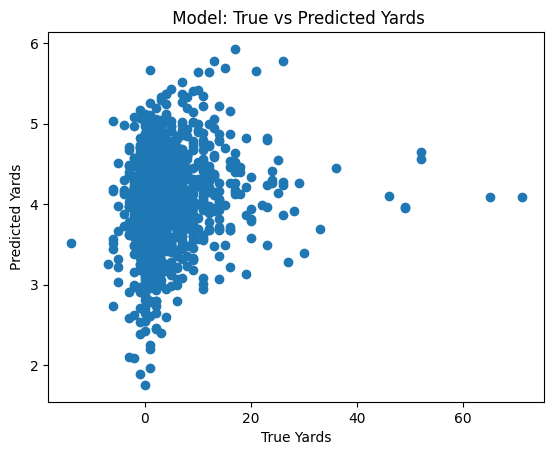

Mean Squared Error: 39.550974149889186
Mean Absolute Error: 3.8864586762323623
Root Mean Squared Error: 6.28895652313555


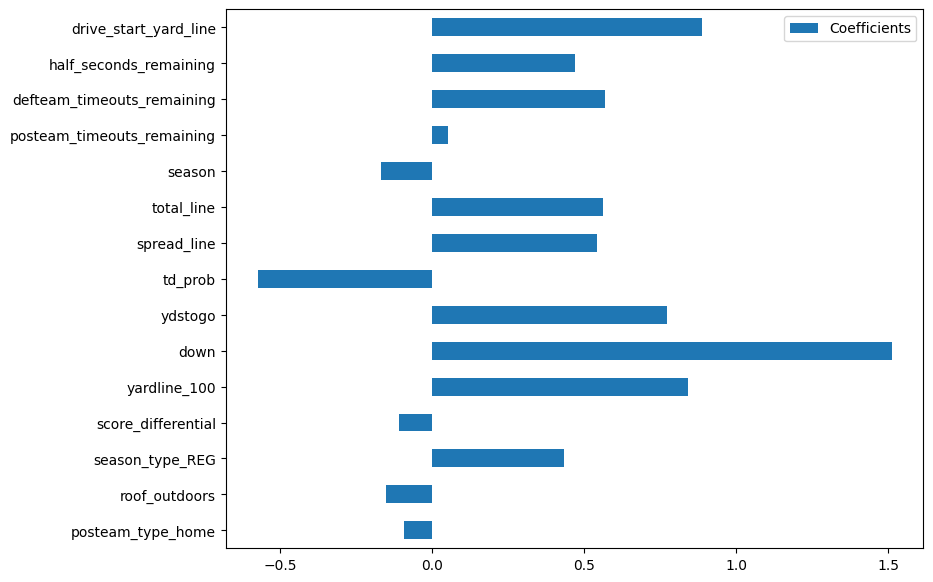

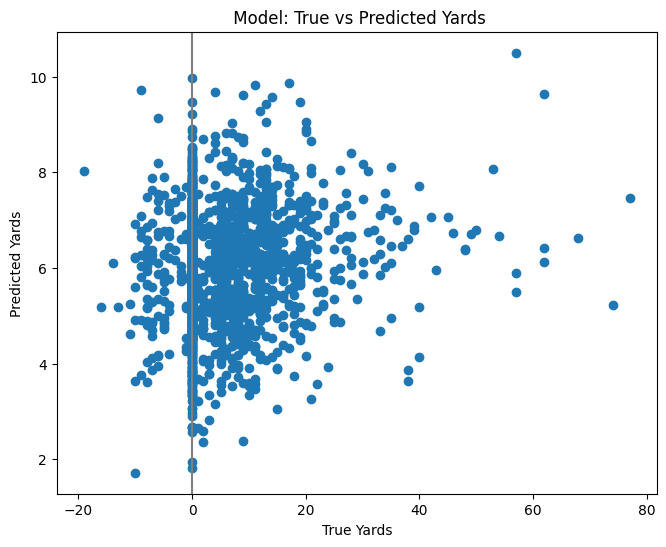

Mean Squared Error: 97.04399601478968
Mean Absolute Error: 7.018658074471631
Root Mean Squared Error: 9.851091107831136


In [73]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.0,
        'loose_factor_iqr': 2.0,
        'strict_columns': ['yardline_100', 'ydstogo'],
        'omit_columns': []
    }
}

pass_params = {
    'outlier_remover__kw_args': {
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }
}

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_y_test, run_predictions = test_model(pipeline, run_df, 0.2)
plot_coef(pipeline)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_y_test, pass_predictions = test_model(pipeline, pass_df, 0.2)
plot_coef(pipeline)

In [60]:
# hyperparameter tuning for linear regression

# could be more over engineered with automatic dict creation if necessary
run_params = {
    'outlier_remover__kw_args': [
        {
            'strict_factor_iqr': 1.0,
            'loose_factor_iqr': 2.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        }, {
            'strict_factor_iqr': 1.5,
            'loose_factor_iqr': 3.0,
            'strict_columns': ['yardline_100', 'ydstogo'],
            'omit_columns': []
        },
    ]
}

pass_params = {
    'outlier_remover__kw_args': [{
        'strict_factor_iqr': 1.5,
        'loose_factor_iqr': 3.0,
        'strict_columns': ['ydstogo'],
        'omit_columns': []
    }]
}

pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_grid_search = estimate_hyperparams(run_df, pipeline, 'neg_mean_squared_error', parameters=run_params, data_fraction=0.25)
pass_grid_search = estimate_hyperparams(pass_df, pipeline, 'neg_mean_squared_error', parameters=pass_params, data_fraction=0.25)

{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['yardline_100', 'ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024008,0.012276,0.004172,0.000240,"{'strict_factor_iqr': 1.0, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-35.890037,-32.987263,-37.022843,-35.300047,1.699518,2
1,0.015185,0.000478,0.003835,0.000235,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-35.911343,-32.689608,-36.876451,-35.159134,1.790117,1


{'outlier_remover__kw_args': {'strict_factor_iqr': 1.5,
  'loose_factor_iqr': 3.0,
  'strict_columns': ['ydstogo'],
  'omit_columns': []}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_outlier_remover__kw_args,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016817,0.001027,0.00367,0.000234,"{'strict_factor_iqr': 1.5, 'loose_factor_iqr':...",{'outlier_remover__kw_args': {'strict_factor_i...,-94.05189,-110.050666,-91.488381,-98.530312,8.213071,1


In [75]:
# make pipelines from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(LinearRegression())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

# set params, test model and save predictions
pipeline = pipeline.set_params(**run_params)
run_y_test, run_predictions = test_model(pipeline, run_df)

# set params, test model and save predictions
pipeline = pipeline.set_params(**pass_params)
pass_y_test, pass_predictions = test_model(pipeline, pass_df)

# visualize predictions
visualize_predicts(run_y_test, run_predictions, LABEL_RUN)
visualize_predicts(pass_y_test, pass_predictions, LABEL_PASS)

ValueError: Invalid parameter 'mlp_params' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].

### Polynomial Regression

Mean Squared Error: 31.153525211030626
Mean Absolute Error: 3.8727676024910997
Root Mean Squared Error: 5.581534306176987
Mean Squared Error: 55.18193215343124
Mean Absolute Error: 5.080493956281428
Root Mean Squared Error: 7.428454223688212


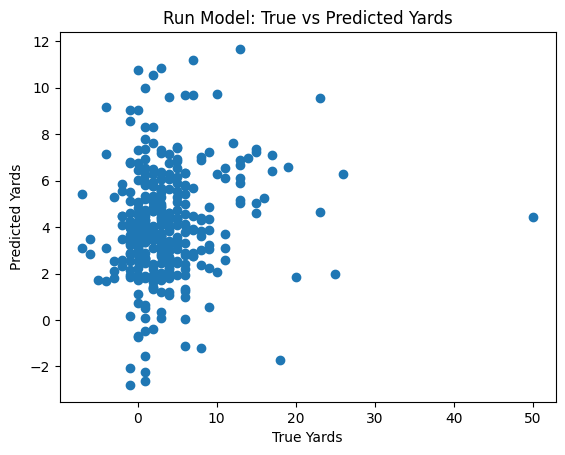

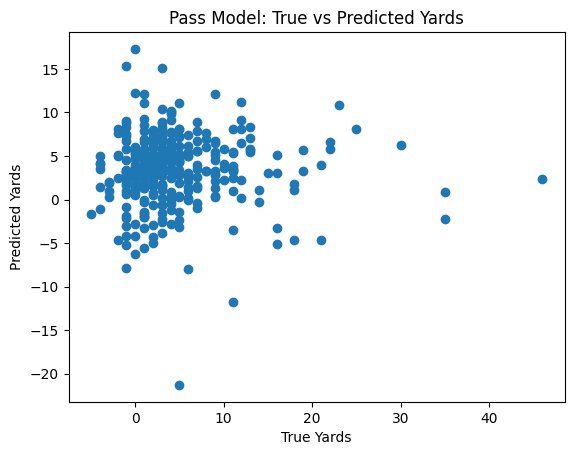

In [40]:
# basic model

# make pipelines from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(2), LinearRegression()))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

In [61]:
# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(), LinearRegression()))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(), LinearRegression()))

parameters = {
    'regressor__polynomialfeatures__degree': [2, 3]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051967,0.002324,0.004425,0.000601,2,{'regressor__polynomialfeatures__degree': 2},-6.284045e+00,-6.623945e+00,-5.256643e+00,-6.054878e+00,5.812441e-01,1
1,0.480184,0.005751,0.005177,0.000471,3,{'regressor__polynomialfeatures__degree': 3},-1.743380e+12,-5.609263e+11,-2.052226e+11,-8.365096e+11,6.574910e+11,2


{'regressor__polynomialfeatures__degree': 2}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047034,0.000610,0.004508,0.000417,2,{'regressor__polynomialfeatures__degree': 2},-1.074473e+01,-1.016064e+01,-10.201550,-1.036897e+01,2.662250e-01,1
1,0.543101,0.007879,0.005559,0.000339,3,{'regressor__polynomialfeatures__degree': 3},-1.892656e+12,-1.624938e+12,-28.989298,-1.172531e+12,8.362775e+11,2


In [50]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df, 0.01)
pass_features, pass_target = split_feature_target(pass_df, 0.01)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(make_pipeline(PolynomialFeatures(), LinearRegression()))

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

pipeline = pipeline.set_params(**run_params)
run_cv_scores = cross_val_score(pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

pipeline = pipeline.set_params(**pass_params)
pass_cv_scores = cross_val_score(pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 588.0865673453688
Pass Model Cross-Validation Mean Squared Error: 1363.474448749543


### KNN

Mean Squared Error: 48.70435347628331
Mean Absolute Error: 4.393762183235867
Root Mean Squared Error: 6.978850440888048
Mean Squared Error: 48.95094217024041
Mean Absolute Error: 4.433723196881092
Root Mean Squared Error: 6.996494991796993


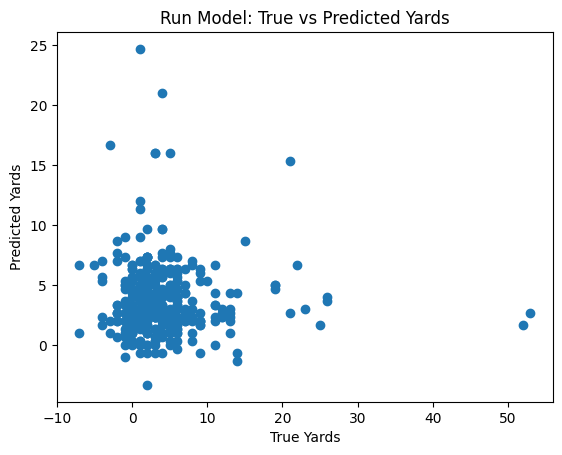

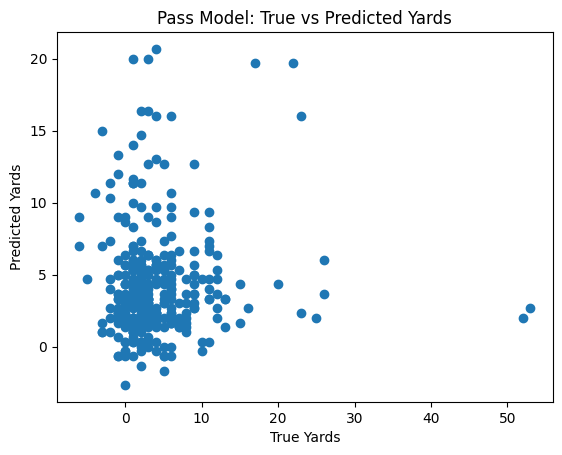

In [41]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor(n_neighbors=3))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

In [62]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

parameters = {
    'regressor__n_neighbors': range(1, 10)
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011682,0.000233,0.006175,0.002404,1,{'regressor__n_neighbors': 1},-8.570400,-7.818125,-7.944588,-8.111038,0.328896,9
1,0.010202,0.001304,0.004834,0.000850,2,{'regressor__n_neighbors': 2},-7.379069,-7.358220,-6.262526,-6.999938,0.521499,8
2,0.010673,0.001176,0.004529,0.000802,3,{'regressor__n_neighbors': 3},-6.906311,-6.874419,-5.798530,-6.526420,0.514860,7
3,0.011685,0.000507,0.006652,0.000561,4,{'regressor__n_neighbors': 4},-6.713861,-6.752075,-5.398120,-6.288019,0.629447,6
4,0.012342,0.000626,0.005837,0.000626,5,{'regressor__n_neighbors': 5},-6.673599,-6.714681,-5.273471,-6.220584,0.669920,5
5,0.011852,0.001038,0.005598,0.000525,6,{'regressor__n_neighbors': 6},-6.595148,-6.675054,-5.123851,-6.131351,0.713157,4
6,0.019758,0.010225,0.006229,0.000635,7,{'regressor__n_neighbors': 7},-6.429866,-6.574533,-5.109968,-6.038123,0.658956,3
7,0.011834,0.000569,0.006188,0.000230,8,{'regressor__n_neighbors': 8},-6.414213,-6.543478,-5.126802,-6.028164,0.639540,2
8,0.013030,0.001099,0.007030,0.000409,9,{'regressor__n_neighbors': 9},-6.378101,-6.523212,-5.086432,-5.995915,0.645824,1


{'regressor__n_neighbors': 9}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014251,0.003599,0.008303,0.003614,1,{'regressor__n_neighbors': 1},-13.259435,-13.212799,-13.401368,-13.291201,0.080193,9
1,0.010923,0.001359,0.006169,0.000240,2,{'regressor__n_neighbors': 2},-11.523933,-11.501576,-11.327357,-11.450955,0.087872,8
2,0.011545,0.000680,0.006423,0.000120,3,{'regressor__n_neighbors': 3},-10.811802,-10.847455,-10.524985,-10.728081,0.144346,7
3,0.010989,0.000684,0.005852,0.000247,4,{'regressor__n_neighbors': 4},-10.490205,-10.443449,-10.160240,-10.364632,0.145782,6
4,0.011508,0.000818,0.005839,0.000471,5,{'regressor__n_neighbors': 5},-10.129364,-10.013188,-9.981660,-10.041404,0.063515,5
5,0.017065,0.009513,0.006338,0.000237,6,{'regressor__n_neighbors': 6},-10.049050,-9.814313,-9.871848,-9.911737,0.099896,4
6,0.011007,0.001081,0.005527,0.001744,7,{'regressor__n_neighbors': 7},-9.964537,-9.709663,-9.739494,-9.804565,0.113771,3
7,0.011581,0.001475,0.006841,0.000438,8,{'regressor__n_neighbors': 8},-9.863700,-9.631797,-9.643777,-9.713092,0.106609,2
8,0.010840,0.000943,0.007003,0.000709,9,{'regressor__n_neighbors': 9},-9.843889,-9.641784,-9.643529,-9.709734,0.094865,1


In [53]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(KNeighborsRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

pipeline = pipeline.set_params(**run_params)
run_cv_scores = cross_val_score(run_pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")

pipeline = pipeline.set_params(**pass_params)
pass_cv_scores = cross_val_score(pass_pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 43.329655169650536
Pass Model Cross-Validation Mean Squared Error: 117.97932168864581


### Random Forest

Mean Squared Error: 36.970206283544165
Mean Absolute Error: 3.661822584280824
Root Mean Squared Error: 6.080313008681721


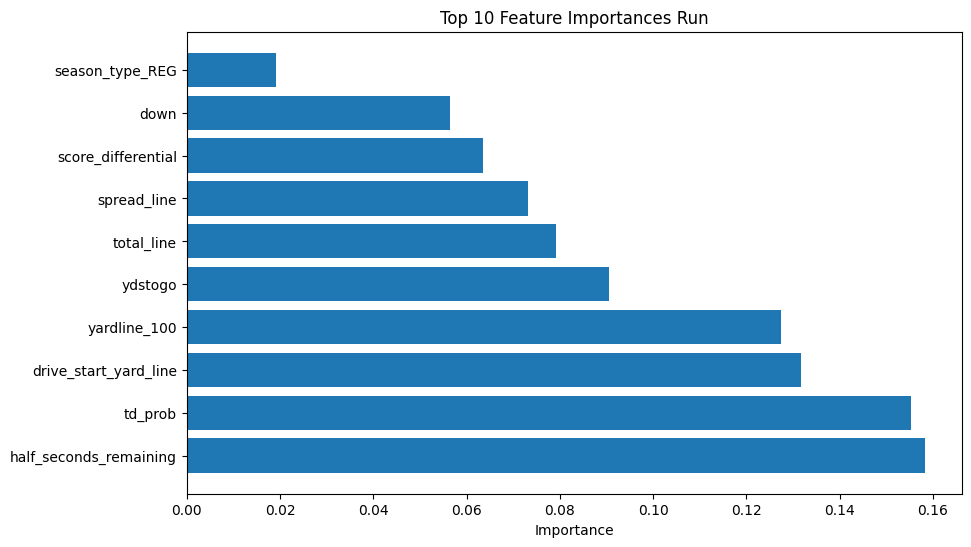

Mean Squared Error: 32.18018308625694
Mean Absolute Error: 3.5385472297655483
Root Mean Squared Error: 5.672757978819204


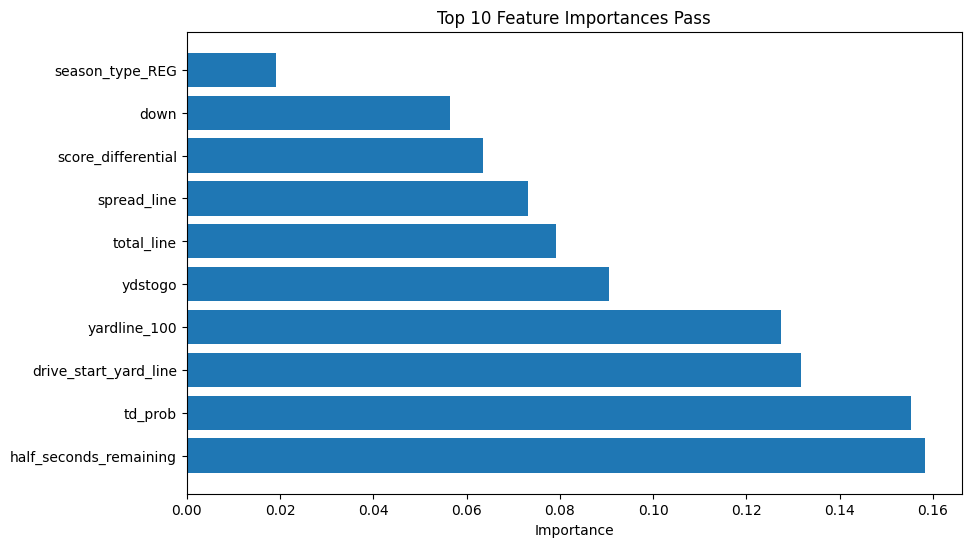

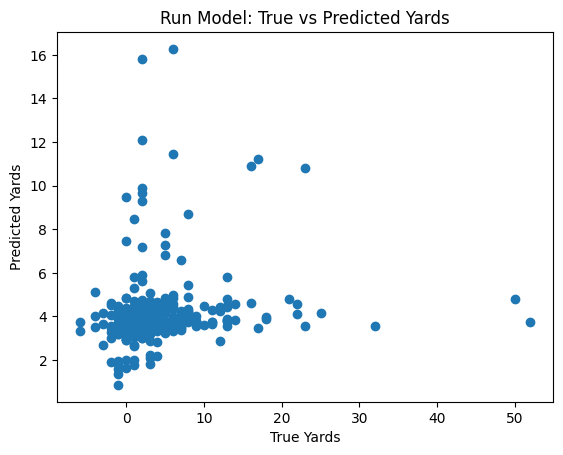

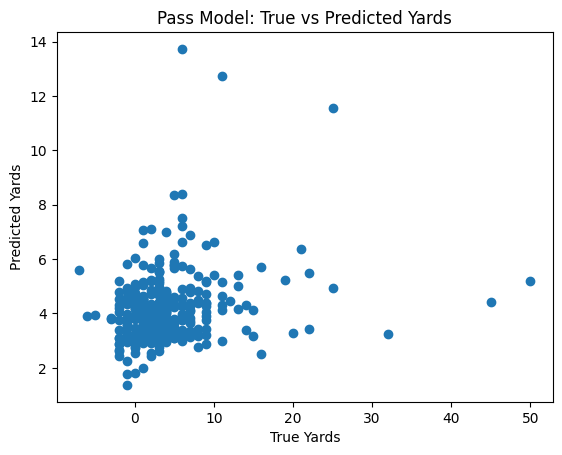

In [48]:
# Basic model

# make pipelines

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5))

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
plot_feature_importances(run_pipeline, LABEL_RUN)

pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)
plot_feature_importances(run_pipeline, LABEL_PASS)

In [63]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

parameters = {
    'regressor__max_depth': range(4, 7),
    'regressor__n_estimators': [20, 50, 100]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__max_depth': 4, 'regressor__n_estimators': 20}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048232,0.003239,0.004671,0.000232,4,20,"{'regressor__max_depth': 4, 'regressor__n_esti...",-5.906802,-6.353950,-4.884908,-5.715220,0.614843,1
1,0.099962,0.003836,0.006002,0.000433,4,50,"{'regressor__max_depth': 4, 'regressor__n_esti...",-5.928691,-6.347816,-4.906287,-5.727598,0.605437,5
2,0.189888,0.008067,0.006159,0.000463,4,100,"{'regressor__max_depth': 4, 'regressor__n_esti...",-5.938413,-6.331235,-4.883159,-5.717602,0.611446,3
3,0.049577,0.002310,0.003667,0.000472,5,20,"{'regressor__max_depth': 5, 'regressor__n_esti...",-5.917443,-6.354489,-4.962726,-5.744886,0.581138,8
4,0.103539,0.002270,0.005007,0.000409,5,50,"{'regressor__max_depth': 5, 'regressor__n_esti...",-5.913350,-6.321951,-4.957203,-5.730835,0.571908,6
5,0.199700,0.004082,0.006600,0.000101,5,100,"{'regressor__max_depth': 5, 'regressor__n_esti...",-5.954145,-6.344532,-4.853995,-5.717557,0.631087,2
6,0.054548,0.001490,0.003836,0.000235,6,20,"{'regressor__max_depth': 6, 'regressor__n_esti...",-5.959271,-6.395698,-4.924987,-5.759985,0.616730,9
7,0.127443,0.007972,0.005020,0.000387,6,50,"{'regressor__max_depth': 6, 'regressor__n_esti...",-5.891126,-6.352691,-4.948863,-5.730893,0.584203,7
8,0.227830,0.009098,0.007007,0.000409,6,100,"{'regressor__max_depth': 6, 'regressor__n_esti...",-5.930152,-6.342675,-4.904404,-5.725744,0.604700,4


{'regressor__max_depth': 4, 'regressor__n_estimators': 20}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046759,0.000636,0.004326,0.000461,4,20,"{'regressor__max_depth': 4, 'regressor__n_esti...",-9.606697,-9.447906,-9.084264,-9.379622,0.218679,1
1,0.097048,0.000117,0.005178,0.000236,4,50,"{'regressor__max_depth': 4, 'regressor__n_esti...",-9.610390,-9.640200,-9.104129,-9.451573,0.245981,5
2,0.193240,0.018854,0.006569,0.000445,4,100,"{'regressor__max_depth': 4, 'regressor__n_esti...",-9.531550,-9.561297,-9.070564,-9.387804,0.224651,2
3,0.051765,0.001984,0.004505,0.000411,5,20,"{'regressor__max_depth': 5, 'regressor__n_esti...",-9.683090,-9.706355,-9.211786,-9.533743,0.227856,8
4,0.113011,0.002802,0.005019,0.000388,5,50,"{'regressor__max_depth': 5, 'regressor__n_esti...",-9.565730,-9.571039,-9.175018,-9.437262,0.185448,3
5,0.214113,0.002634,0.006342,0.000615,5,100,"{'regressor__max_depth': 5, 'regressor__n_esti...",-9.572923,-9.622063,-9.156889,-9.450625,0.208669,4
6,0.059613,0.002455,0.004282,0.000214,6,20,"{'regressor__max_depth': 6, 'regressor__n_esti...",-9.709086,-9.762193,-9.282778,-9.584686,0.214579,9
7,0.128794,0.001584,0.005193,0.000484,6,50,"{'regressor__max_depth': 6, 'regressor__n_esti...",-9.662018,-9.640742,-9.236602,-9.513121,0.195721,7
8,0.259464,0.009659,0.007169,0.000236,6,100,"{'regressor__max_depth': 6, 'regressor__n_esti...",-9.622679,-9.606483,-9.232393,-9.487185,0.180286,6


In [56]:
# cross-validation with best hyperparameters

run_features, run_target = split_feature_target(run_df)
pass_features, pass_target = split_feature_target(pass_df)

# make new pipeliness from preprocessing script
pipeline = PREPROCESSOR.make_preprocessing_pipeline(RandomForestRegressor())

run_params = run_grid_search.best_params_
pass_params = pass_grid_search.best_params_

pipeline = pipeline.set_params(**run_params)
run_cv_scores = cross_val_score(pipeline, run_features, run_target, cv=5, scoring='neg_mean_squared_error')
print(f"Run Model Cross-Validation Mean Squared Error: {-np.mean(run_cv_scores)}")
pipeline = pipeline.set_params(**pass_params)
pass_cv_scores = cross_val_score(pipeline, pass_features, pass_target, cv=5, scoring='neg_mean_squared_error')
print(f"Pass Model Cross-Validation Mean Squared Error: {-np.mean(pass_cv_scores)}")

Run Model Cross-Validation Mean Squared Error: 36.72402816597404
Pass Model Cross-Validation Mean Squared Error: 97.76453896460143


Mean Squared Error: 32.506935871156664
Mean Absolute Error: 3.925534407027819
Root Mean Squared Error: 5.701485409185633
Mean Squared Error: 107.4438306930693
Mean Absolute Error: 7.381175742574257
Root Mean Squared Error: 10.365511598231382


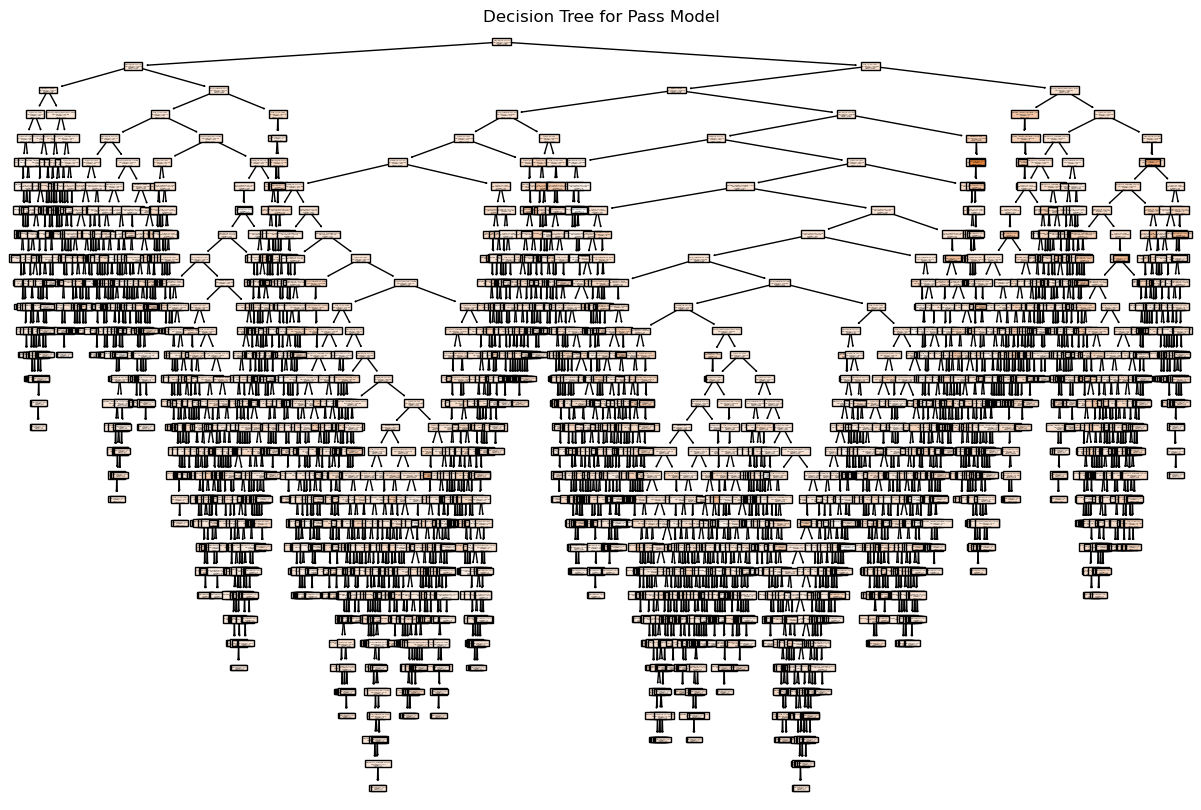

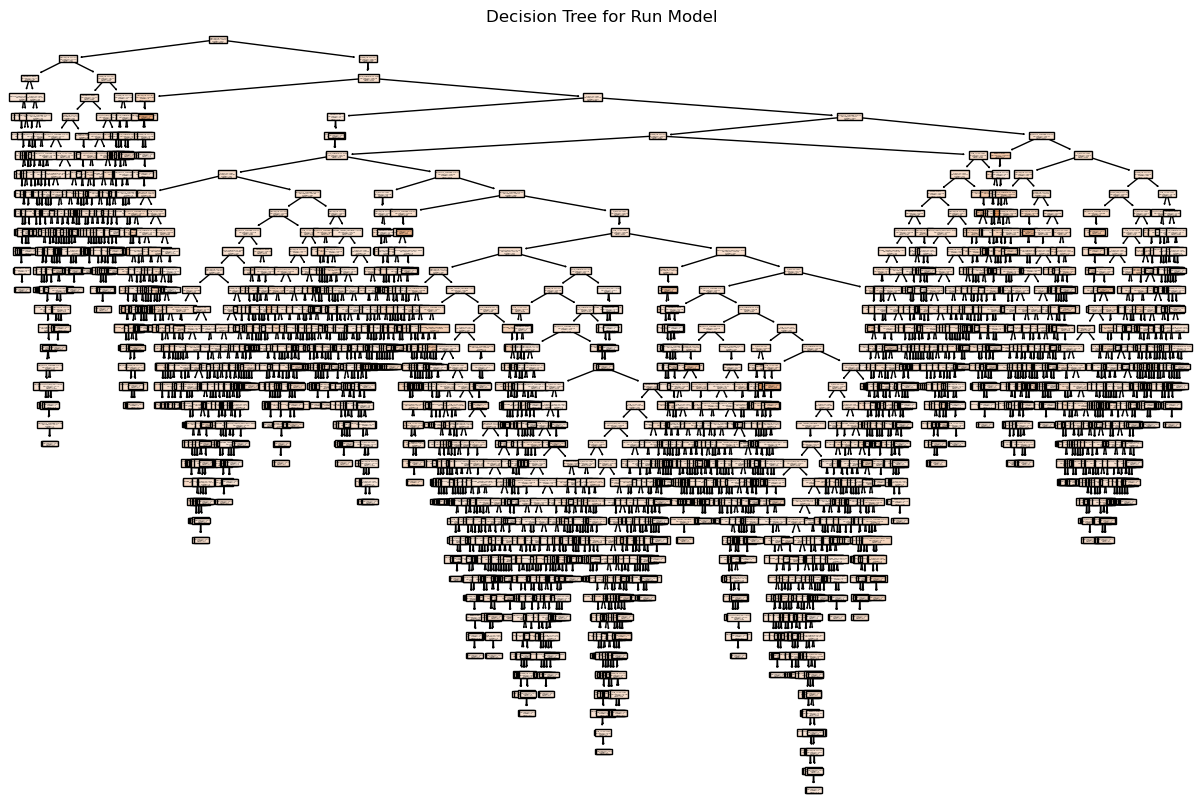

In [57]:
# visualize decision tree
# test model
test_model(run_pipeline, run_X_train, run_y_train, run_X_test, run_y_test)
test_model(pass_pipeline, pass_X_train, pass_y_train, pass_X_test, pass_y_test)

# Access a specific tree from the forest (e.g., the first tree)
tree_to_plot_pass = 0
tree_to_plot_run = 0

pass_rf_regressor = pass_pipeline.named_steps['regressor']
run_rf_regressor = run_pipeline.named_steps['regressor']

# Access the decision tree from the Random Forest
individual_tree_pass = pass_rf_regressor.estimators_[tree_to_plot_pass]
individual_tree_run = run_rf_regressor.estimators_[tree_to_plot_run]

# Plot the decision tree for passes
plot_decision_tree(individual_tree_pass, LABEL_PASS)

# Plot the decision tree for runs
plot_decision_tree(individual_tree_run, LABEL_RUN)

### XGBoost

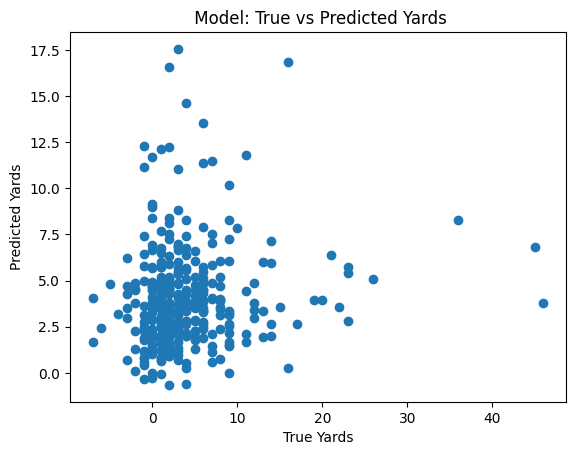

Mean Squared Error: 39.64448023495106
Mean Absolute Error: 4.090625606030661
Root Mean Squared Error: 6.296386283810029


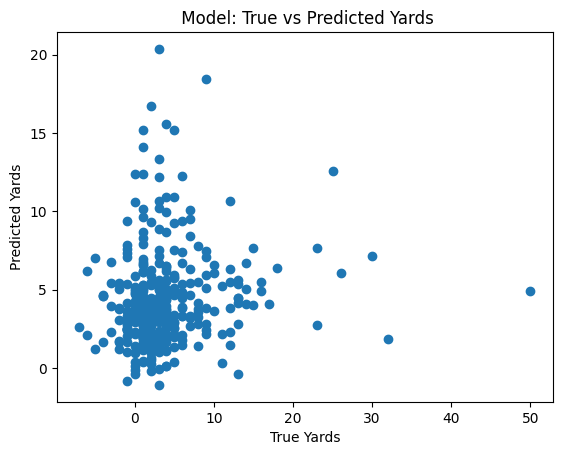

Mean Squared Error: 38.18057461682106
Mean Absolute Error: 4.193823360843442
Root Mean Squared Error: 6.179043179718124


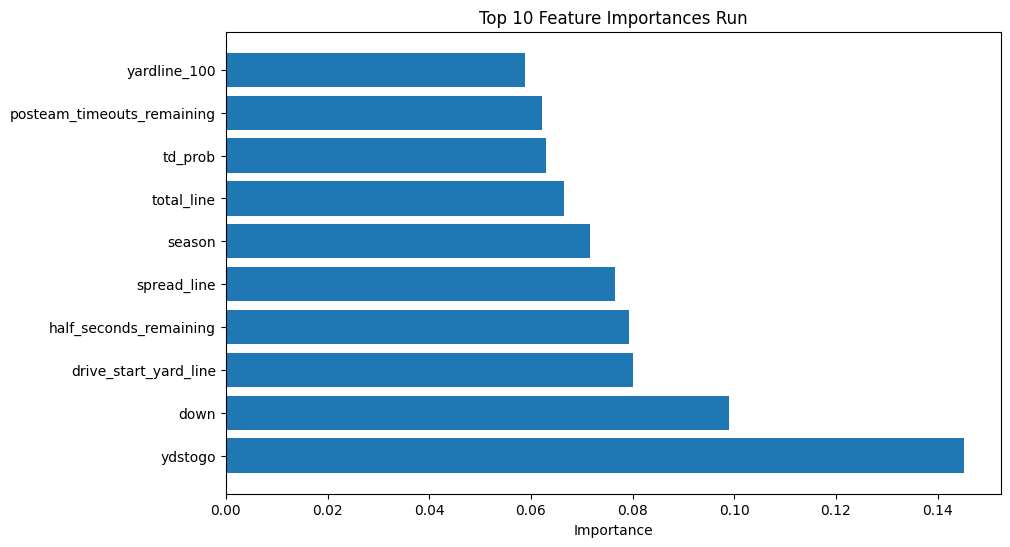

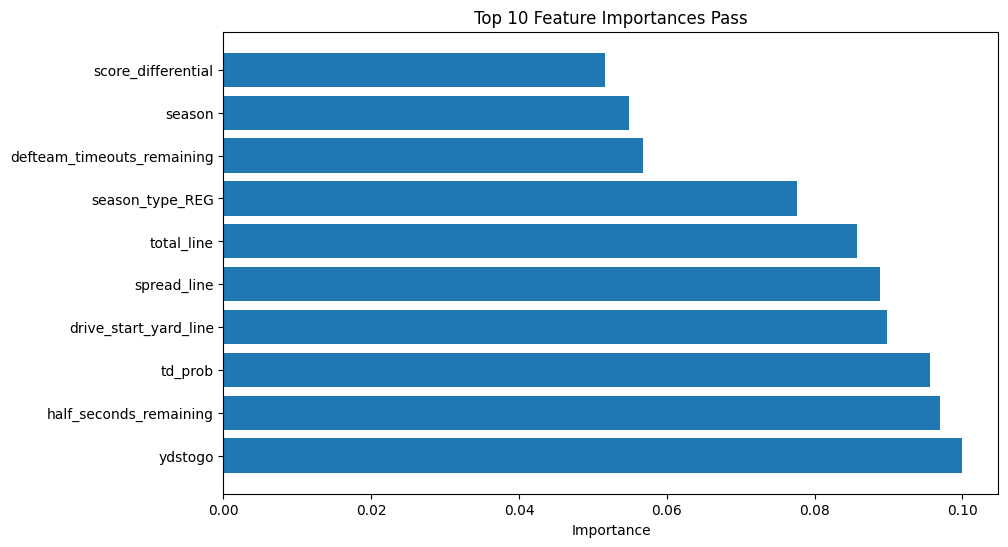

In [76]:
# Basic model

# make pipelines
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.022,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
                           )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    xgb.XGBRegressor(
        learning_rate = 0.015,
        n_estimators  = 1000,
        max_depth     = 8,
        eval_metric='rmsle'
        )
)

# test model and save predictions
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.05)
pass_y_test, pass_predictions = test_model(pass_pipeline, run_df, 0.05)

plot_feature_importances(run_pipeline, LABEL_RUN)
plot_feature_importances(pass_pipeline, LABEL_PASS)

In [64]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(xgb.XGBRegressor())

parameters = {
    "regressor__max_depth":    [8, 10],
    "regressor__n_estimators": [1000, 1100],
    "regressor__learning_rate": [0.022, 0.015]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__learning_rate': 0.015,
 'regressor__max_depth': 8,
 'regressor__n_estimators': 1000}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.973410,0.101961,0.006502,0.000408,0.022,8,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-6.038412,-6.596418,-5.436941,-6.023924,0.473466,3
1,0.989108,0.018137,0.007839,0.000851,0.022,8,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-6.040150,-6.596529,-5.438799,-6.025159,0.472760,4
2,1.479244,0.082226,0.016679,0.012623,0.022,10,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-6.140195,-6.559546,-5.643702,-6.114481,0.374334,5
3,1.635763,0.033224,0.008843,0.000855,0.022,10,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-6.140275,-6.559711,-5.643943,-6.114643,0.374300,6
4,0.911312,0.046511,0.007006,0.000409,0.015,8,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-6.052271,-6.588630,-5.382792,-6.007898,0.493281,1
5,0.957648,0.031305,0.008730,0.000906,0.015,8,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-6.057868,-6.591479,-5.394387,-6.014578,0.489668,2
6,1.462340,0.054833,0.015018,0.009575,0.015,10,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-6.168822,-6.612668,-5.567605,-6.116365,0.428255,7
7,1.630409,0.037295,0.008179,0.000466,0.015,10,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-6.169465,-6.612866,-5.569636,-6.117323,0.427490,8


{'regressor__learning_rate': 0.015,
 'regressor__max_depth': 8,
 'regressor__n_estimators': 1000}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.893055,0.041845,0.007340,0.000849,0.022,8,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-10.630670,-10.672902,-10.223115,-10.508896,0.202812,5
1,0.962440,0.040974,0.007179,0.000474,0.022,8,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-10.636910,-10.676663,-10.228291,-10.513955,0.202646,6
2,1.495383,0.083451,0.016181,0.009470,0.022,10,1000,"{'regressor__learning_rate': 0.022, 'regressor...",-10.650694,-10.564232,-10.280014,-10.498313,0.158345,3
3,1.911487,0.157619,0.008006,0.000409,0.022,10,1100,"{'regressor__learning_rate': 0.022, 'regressor...",-10.651434,-10.564651,-10.280256,-10.498780,0.158529,4
4,0.913010,0.029980,0.006843,0.000474,0.015,8,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-10.589905,-10.604767,-10.135235,-10.443303,0.217921,1
5,0.991990,0.027487,0.007841,0.001248,0.015,8,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-10.607594,-10.610712,-10.147694,-10.455333,0.217537,2
6,1.461272,0.081513,0.015520,0.009608,0.015,10,1000,"{'regressor__learning_rate': 0.015, 'regressor...",-10.639033,-10.771239,-10.335159,-10.581810,0.182569,7
7,1.663433,0.054299,0.008347,0.000630,0.015,10,1100,"{'regressor__learning_rate': 0.015, 'regressor...",-10.643927,-10.775535,-10.337749,-10.585737,0.183401,8


### Artificial Neuronal Network

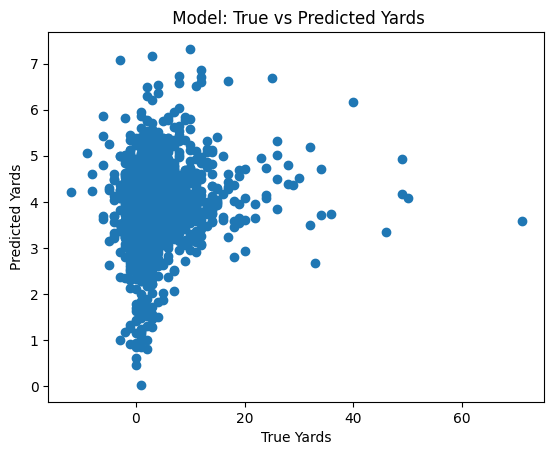

Mean Squared Error: 36.63378236172362
Mean Absolute Error: 3.753475802568599
Root Mean Squared Error: 6.052584767000262


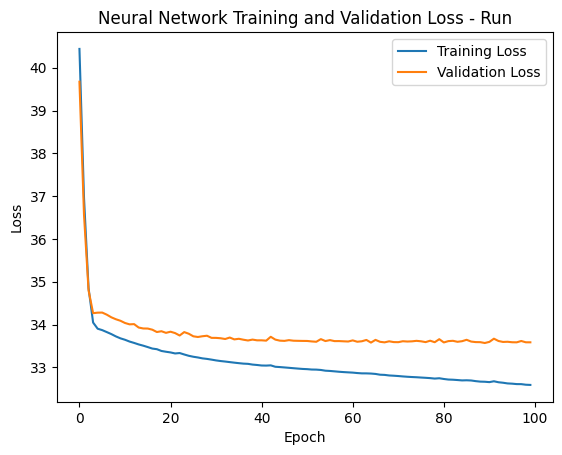

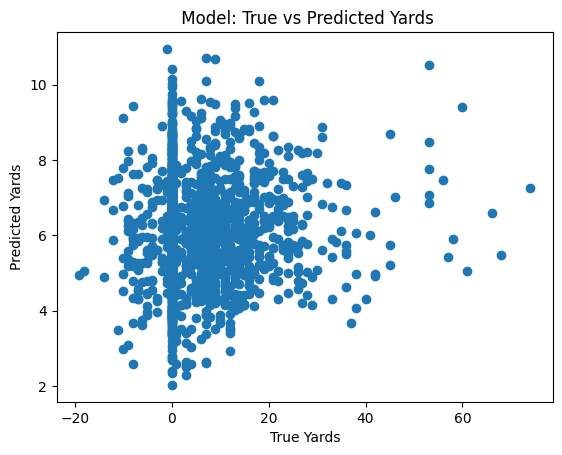

Mean Squared Error: 100.04024833232401
Mean Absolute Error: 7.280208840228574
Root Mean Squared Error: 10.002012214165909


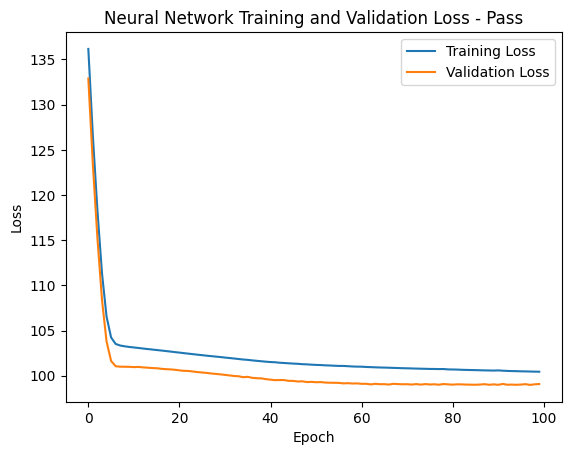

In [78]:
# Basic model

run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(
    MLPWithHistory(
        mlp_params={'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}
    )
)

# estimate run model
run_y_test, run_predictions = test_model(run_pipeline, run_df, 0.2)
run_mlp = run_pipeline.named_steps['regressor']
visualize_train_val_loss(run_mlp.training_losses, run_mlp.validation_losses, LABEL_RUN)

# estimate pass model
pass_y_test, pass_predictions = test_model(pass_pipeline, pass_df, 0.2)
pass_mlp = pass_pipeline.named_steps['regressor']
visualize_train_val_loss(pass_mlp.training_losses, pass_mlp.validation_losses, LABEL_PASS)

In [65]:
# estimating hyperparameters

# make new pipeliness from preprocessing script
run_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())
pass_pipeline = PREPROCESSOR.make_preprocessing_pipeline(MLPWithHistory())

parameters = {
    'regressor__mlp_params': [
        {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
        {'hidden_layer_sizes': (20, 10), 'activation': 'relu', 'solver': 'adam', 'max_iter': 100},
    ]
}

run_grid_search = estimate_hyperparams(run_df, run_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)
pass_grid_search = estimate_hyperparams(pass_df, pass_pipeline, 'neg_root_mean_squared_error', k_folds=3, parameters=parameters, data_fraction=0.05)

{'regressor__mlp_params': {'hidden_layer_sizes': (50,),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.097411,0.007087,0.003357,0.000250,"{'hidden_layer_sizes': (10,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-6.148073,-6.337839,-4.841299,-5.775737,0.665274,4
1,0.240159,0.006984,0.004889,0.001617,"{'hidden_layer_sizes': (50,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-6.110306,-6.320961,-4.796370,-5.742546,0.674552,1
2,0.117725,0.003078,0.003171,0.000240,"{'hidden_layer_sizes': (10, 5), 'activation': ...",{'regressor__mlp_params': {'hidden_layer_sizes...,-6.172585,-6.336065,-4.790565,-5.766405,0.693243,3
3,0.137307,0.005565,0.003172,0.000241,"{'hidden_layer_sizes': (20, 10), 'activation':...",{'regressor__mlp_params': {'hidden_layer_sizes...,-6.133947,-6.309414,-4.812922,-5.752095,0.667947,2


{'regressor__mlp_params': {'hidden_layer_sizes': (10, 5),
  'activation': 'relu',
  'solver': 'adam',
  'max_iter': 100}}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__mlp_params,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110239,0.002619,0.003339,0.001210,"{'hidden_layer_sizes': (10,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-9.547321,-9.290410,-9.073522,-9.303751,0.193657,3
1,0.305557,0.002013,0.003340,0.000239,"{'hidden_layer_sizes': (50,), 'activation': 'r...",{'regressor__mlp_params': {'hidden_layer_sizes...,-9.470136,-9.357954,-9.080943,-9.303011,0.163568,2
2,0.127911,0.001309,0.003335,0.000473,"{'hidden_layer_sizes': (10, 5), 'activation': ...",{'regressor__mlp_params': {'hidden_layer_sizes...,-9.514688,-9.331289,-9.057525,-9.301167,0.187847,1
3,0.146203,0.001161,0.003836,0.000234,"{'hidden_layer_sizes': (20, 10), 'activation':...",{'regressor__mlp_params': {'hidden_layer_sizes...,-9.492588,-9.393427,-9.057127,-9.314381,0.186356,4
